# Differentiating Metal-Poor Main-Sequence Stars from White Dwarfs

In this notebook, we walk through the basic procedure to use our logistic regression classifier to compute the probability that a given star is a main-sequence star (as opposed to a white dwarf) on the basis of spectro-photometric observables. Our full rationale and methodology is described in Chandra & Schlaufman (2020, in prep.) **[add link]**. 

For questions or comments, please don't hesitate to [contact the authors](https://vedantchandra.com) or [raise an issue on GitHub.](https://github.com/vedantchandra/mpms/issues). 

In [137]:
import numpy as np
import matplotlib.pyplot as plt

import lmfit
import pandas as pd
import scipy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': 16})

## Load Test Data

We load the SDSS spectra and _ugriz_ colors for two random stars we selected from SDSS DR16, one white dwarf (WD) and one metal-poor main sequence (MPMS) star. We know _a priori_ that Star 1 is a white dwarf and Star 2 is an MPMS star. 

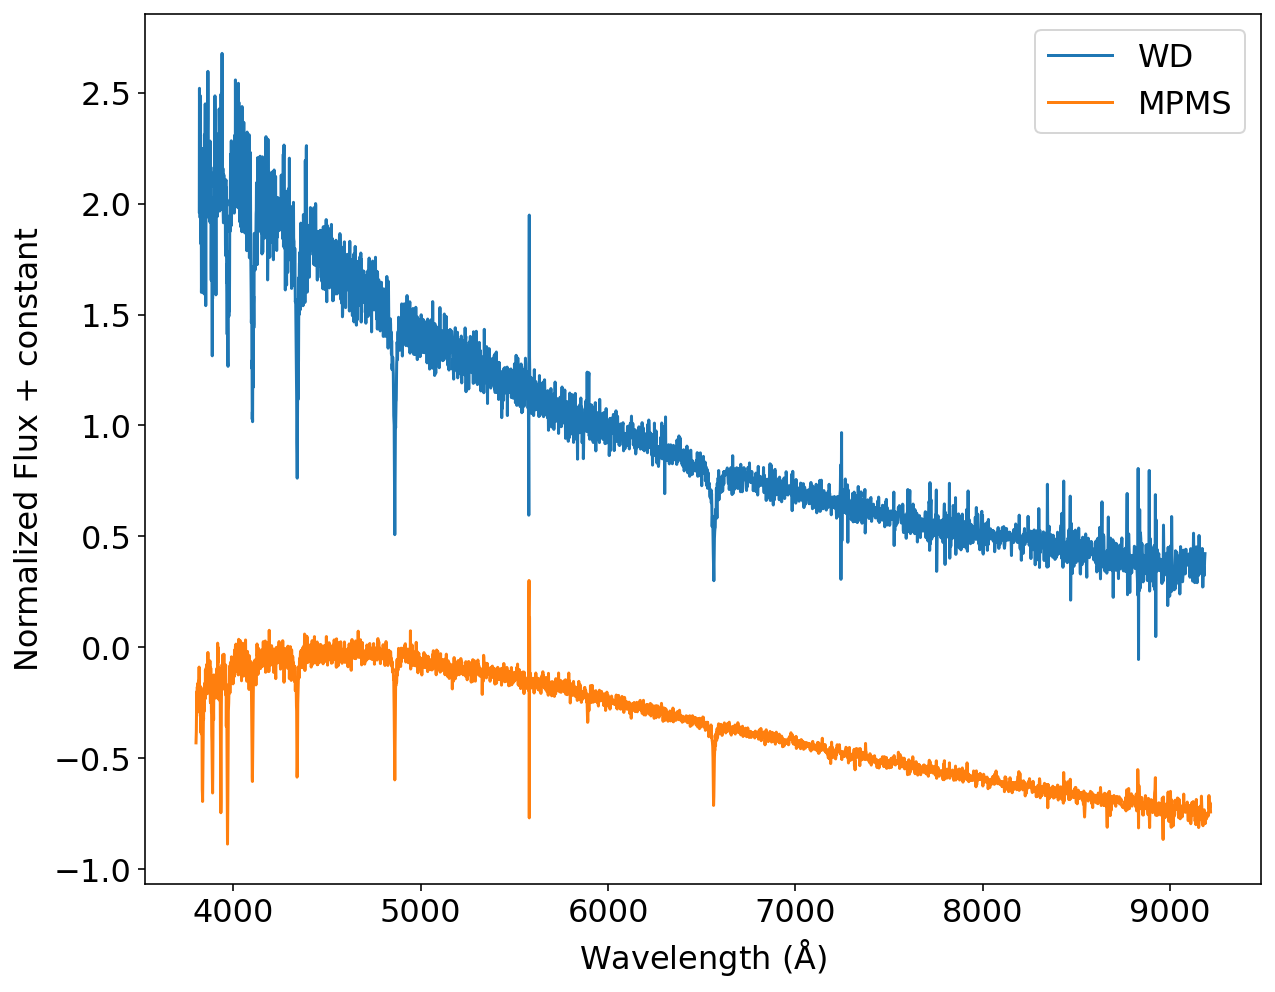

In [172]:
wd_wl, wd_fl = np.loadtxt('test_data/wd_spec.txt')
mpms_wl, mpms_fl = np.loadtxt('test_data/mpms_spec.txt')

wd_ugriz = np.loadtxt('test_data/wd_phot.txt')
mpms_ugriz = np.loadtxt('test_data/mpms_phot.txt')

plt.figure(figsize = (10, 8))

wd_fl = wd_fl #/ scipy.ndimage.gaussian_filter1d(wd_fl, 100) # Continuum-normalization
mpms_fl = mpms_fl #/ scipy.ndimage.gaussian_filter1d(mpms_fl, 100) 


plt.plot(wd_wl, wd_fl / np.nanmedian(wd_fl), label = 'WD')
plt.plot(mpms_wl, mpms_fl / np.median(mpms_fl) - 1.25, label = 'MPMS')

plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Normalized Flux + constant')

plt.legend();

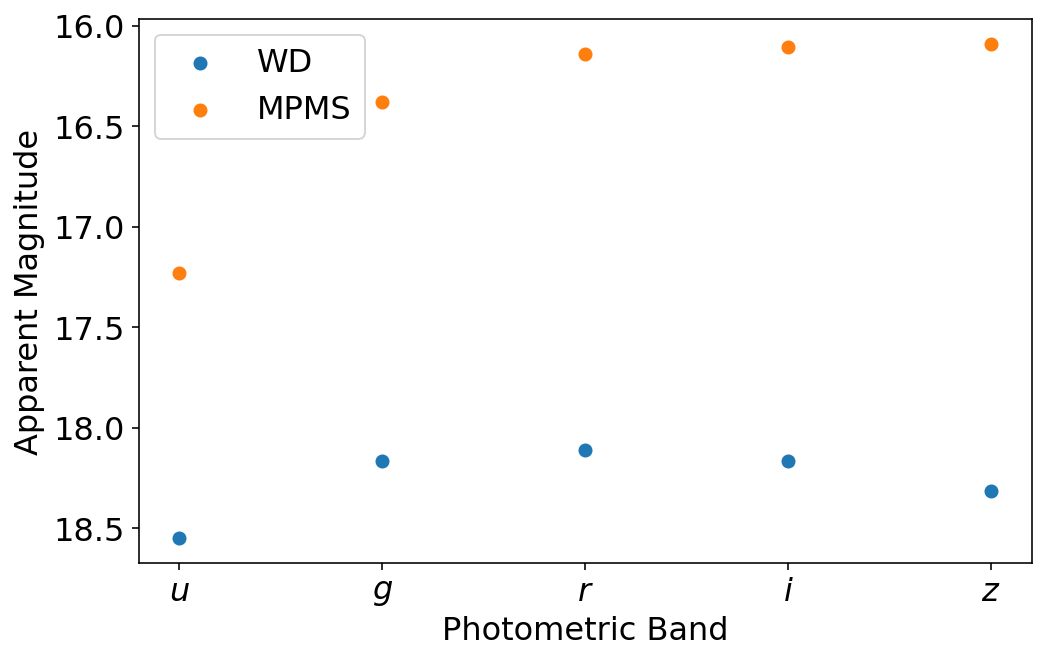

In [173]:
plt.figure(figsize = (8, 5))

bands = ['$u$', '$g$', '$r$', '$i$', '$z$']
colors = ['$u-g$', '$g-r$', '$r-i$', '$i-z$']

plt.scatter(bands, wd_ugriz, label = 'WD')
plt.scatter(bands, mpms_ugriz, label = 'MPMS')

plt.xlabel('Photometric Band')
plt.ylabel('Apparent Magnitude')

plt.gca().invert_yaxis()
plt.legend();

We compute the _ugriz_ color space by taking the difference of succesive apparent magnitudes:

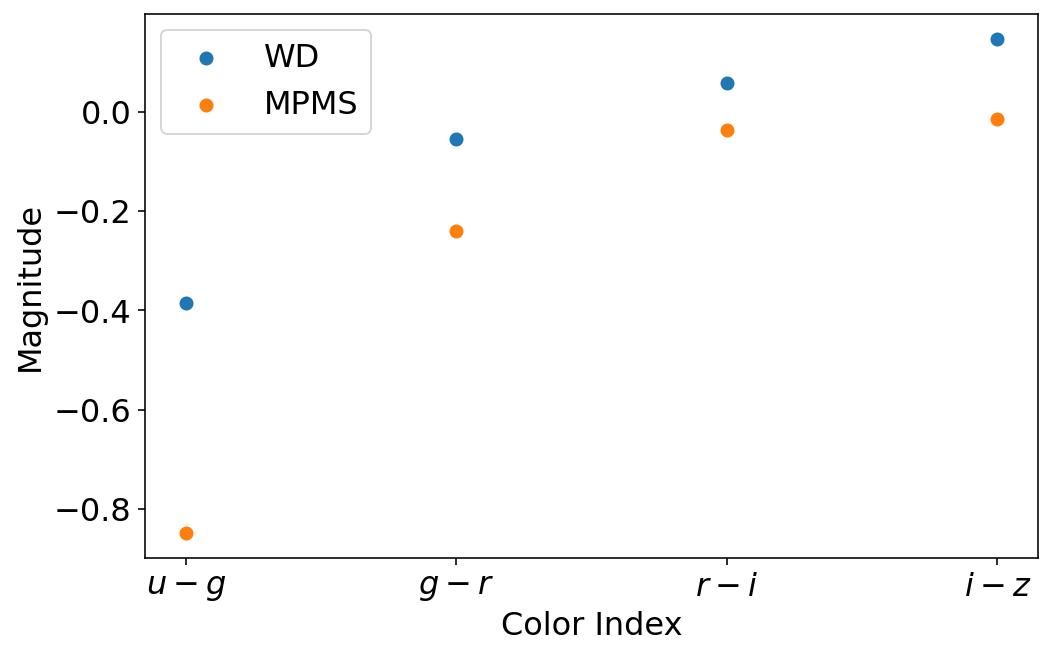

In [174]:
wd_colors = np.diff(wd_ugriz)
mpms_colors = np.diff(mpms_ugriz)

plt.figure(figsize = (8, 5))

plt.scatter(colors, wd_colors, label = 'WD')
plt.scatter(colors, mpms_colors, label = 'MPMS')
plt.xlabel('Color Index')
plt.ylabel('Magnitude')
plt.legend()

## Get Balmer Line Summaries

We now fit the Balmer lines of the spectra to compute the line summaries used in our classifier. We provide a convenience function to automatically fit the selected Balmer lines with Voigt profiles using LMFIT.

If, for example, only the first 3 Balmer lines are present in your data, then you can modify the argument when initializing LineProfiles to only fit alpha, beta and gamma. 

In [175]:
from classify_mpms import LineProfiles

lp = LineProfiles(lines = ['alpha', 'beta', 'gamma', 'delta']) # Load convenience class for line profile fitting

We specify the spectroscopic features that we want - the classifier accepts FWHM and height summaries. The LineProfiles class returns other information like line centres as well and returns everything as a pandas dataframe, so we use an array of labels to specify which features we want.

In [176]:
spec_features = ['a_fwhm', 'a_height',
       'b_fwhm', 'b_height',
       'g_fwhm', 'g_height',
         'd_fwhm', 'd_height']

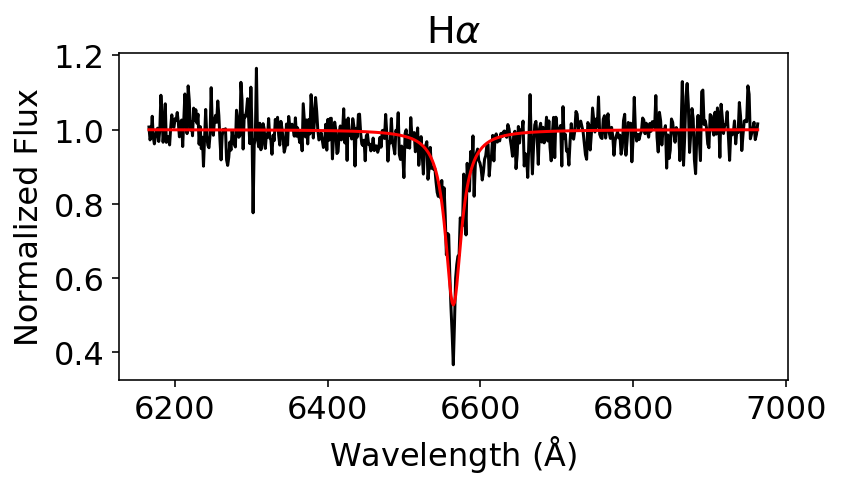

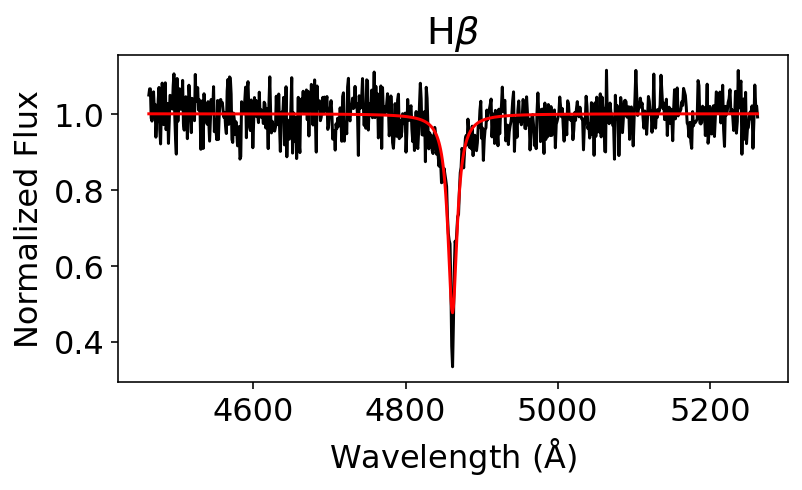

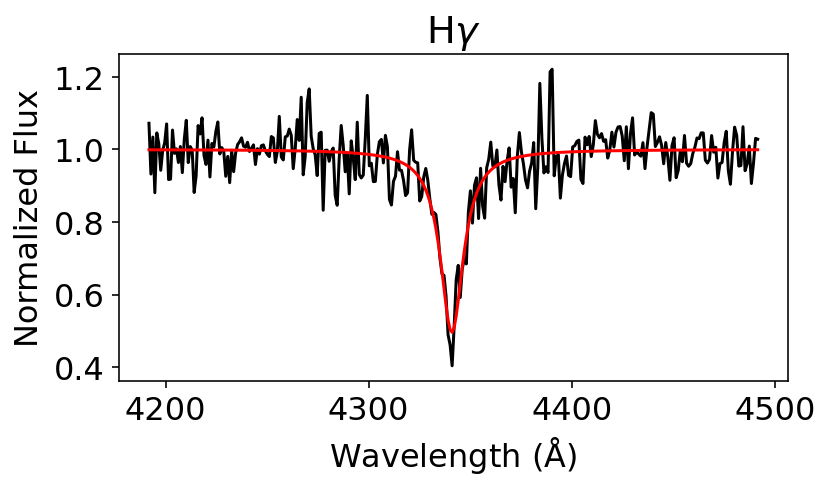

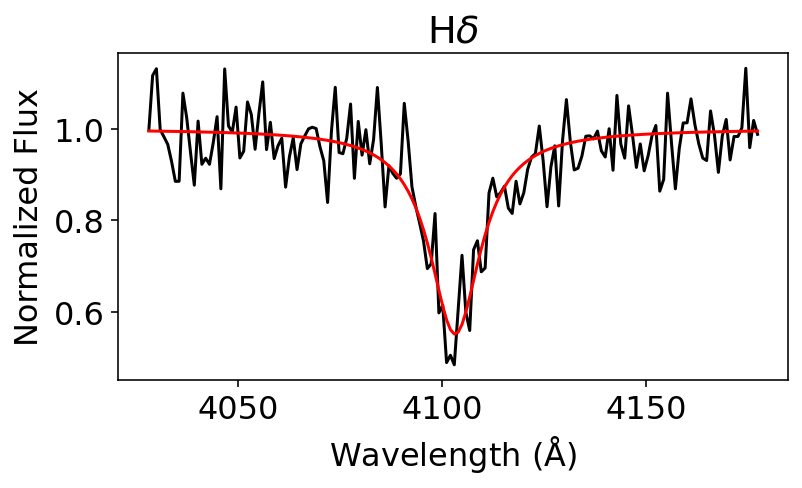

In [177]:
wd_balmer = lp.fit_balmer(wd_wl, wd_fl, make_plot = True)[spec_features]

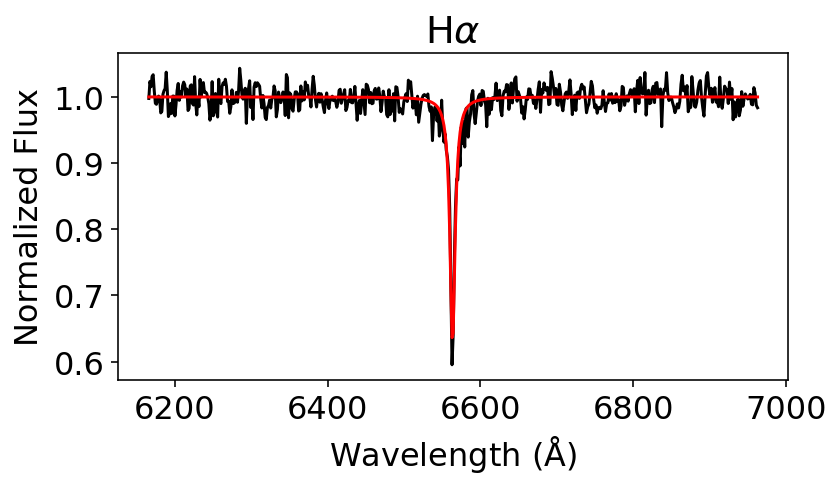

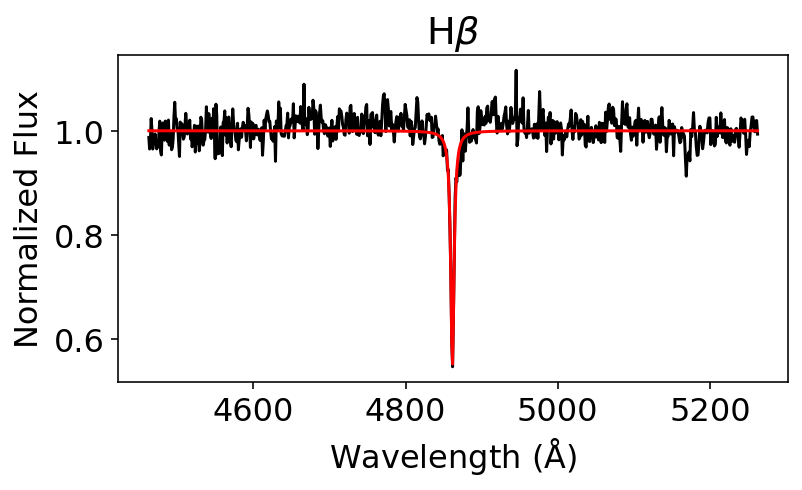

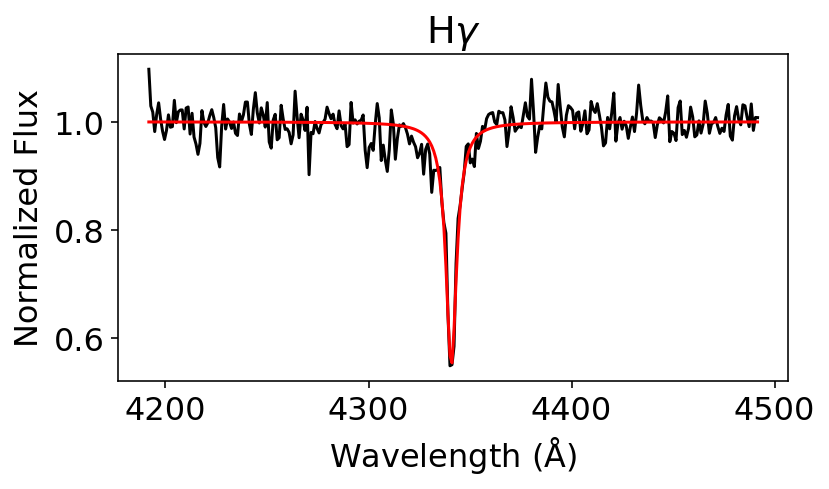

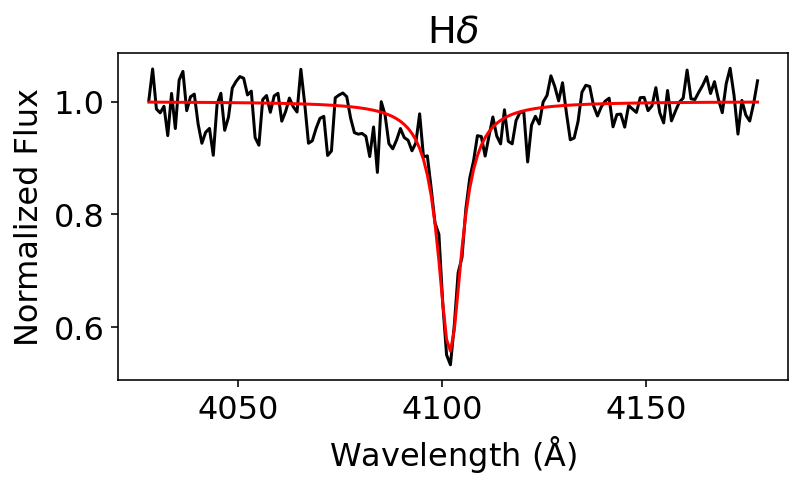

In [178]:
mpms_balmer = lp.fit_balmer(mpms_wl, mpms_fl, make_plot = True)[spec_features]

We can look at what kind of data structure is returned:

In [179]:
wd_balmer

,a_fwhm,a_height,b_fwhm,b_height,g_fwhm,g_height,d_fwhm,d_height
0,25.475974,0.472479,14.626116,0.524298,13.713839,0.504494,15.20805,0.449133


## Combine Data

Now we merge the Balmer line summary data with the _ugriz_ color summary data to generate our final feature vectors that we provide to the classifier. We also stack the data from the two provided stars together. The classifier code is designed to accept multiple stars at once - this can be extended to any arbitrary number of stars. 

In [180]:
wd_features = np.hstack((wd_colors, np.array(wd_balmer)[0])).reshape(1, -1)
mpms_features = np.hstack((mpms_colors, np.array(mpms_balmer)[0])).reshape(1, -1)

data = np.vstack((wd_features, mpms_features)) # Combine both stars into one dataset

## Classify

We can now feed our dataset into the classifier to compute the probability that each star is a metal-poor main sequence star as opposed to a white dwarf. 

The logistic regression classifier trains itself on the provided training grid based on which features the user selects. So, for example, if your data lacks _u_ band photometry, then simply remove $\texttt{'ug'}$ from the list of features when initializing the classifier, and it will ignore that observable during the training. 

It is important to ensure that the features you provide the classifier when initializing it are the same features (and in the same order) as the features in your data! 

In [181]:
from classify_mpms import LRClassifier

features = ['ug', 'gr', 'ri', 'iz']
features.extend(spec_features)

print(features)

['ug', 'gr', 'ri', 'iz', 'a_fwhm', 'a_height', 'b_fwhm', 'b_height', 'g_fwhm', 'g_height', 'd_fwhm', 'd_height']


In [182]:
lrc = LRClassifier(features = features, training_grid = 'training_grid.csv') # Initialize classifier

We are now ready to classify!

In [183]:
p_mpms = lrc.classify(data)

print('Star 1 P(MPMS) = %.2f' % p_mpms[0])
print('Star 2 P(MPMS) = %.2f' % p_mpms[1])

Star 1 P(MPMS) = 0.06
Star 2 P(MPMS) = 0.92


We already know _a priori_ that Star 1 is a white dwarf and star 2 is a metal-poor main-sequence star, and the classified probabilities correctly reflect this. Done!

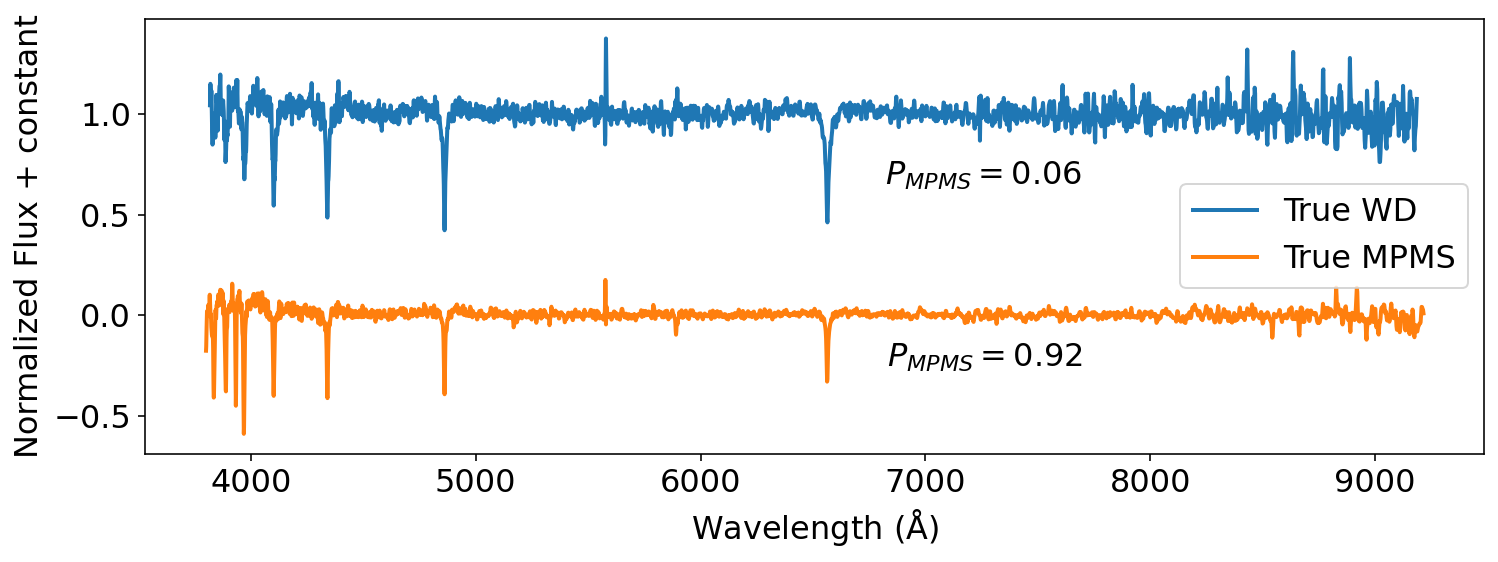

In [207]:
wd_wl, wd_fl = np.loadtxt('test_data/wd_spec.txt')
mpms_wl, mpms_fl = np.loadtxt('test_data/mpms_spec.txt')

wd_ugriz = np.loadtxt('test_data/wd_phot.txt')
mpms_ugriz = np.loadtxt('test_data/mpms_phot.txt')

plt.figure(figsize = (12, 4))

## Smoothing and continuum-normalizing for plot:

wd_fl = scipy.ndimage.gaussian_filter1d(wd_fl, 1) / scipy.ndimage.gaussian_filter1d(wd_fl, 100) 
mpms_fl = scipy.ndimage.gaussian_filter1d(mpms_fl, 1) / scipy.ndimage.gaussian_filter1d(mpms_fl, 100) 

plt.plot(wd_wl, wd_fl, label = 'True WD', lw = 2)
plt.plot(mpms_wl, mpms_fl - 1, label = 'True MPMS', lw = 2)

plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Normalized Flux + constant')

plt.legend();

plt.text(0.7, 0.62, '$P_{MPMS} = %.2f$' % p_mpms[0], ha = 'right', transform = plt.gca().transAxes)
plt.text(0.7, 0.2, '$P_{MPMS} = %.2f$' % p_mpms[1], ha = 'right', transform = plt.gca().transAxes)

plt.savefig('test_data/spectra.png', dpi = 100, bbox_inches = 'tight')

### Data-Driven Training Grid

In addition to the training grid derived from theoretical models (more details are in the paper), we also provide a data-driven training grid based on features from ~1500 real stars with SDSS data. All these stars have reliable parallaxes from Gaia, which enables a definitive classification between MPMS and WD based on absolute magnitude. 

Users are free to use this data-driven training grid, however, we caution that it's only reliable for stars similar to those from the original SDSS training data. Therefore, it will be quite unreliable for the unobserved portions of the parameter space, for example low-temperature stars with $T_{\rm eff} \lesssim 6000$ K. 

In [200]:
lrc_dd = LRClassifier(features = features, training_grid = 'dd_grid.csv')

In [201]:
p_mpms_dd = lrc_dd.classify(data)

print('Star 1 P(MPMS) = %.2f' % p_mpms_dd[0])
print('Star 2 P(MPMS) = %.2f' % p_mpms_dd[1])

Star 1 P(MPMS) = 0.01
Star 2 P(MPMS) = 0.96


In this case, the results from the data-driven and theoretical training grids are quite consistent, although the data-driven model is more specific in rejecting the WD as a non-MPMS star. 